In [1]:
import torch
from torch import nn
from torch.optim import Adam
from model import load_models
import random
from prepared import load_voc, batch2train_data
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data, Vocabulary = load_voc()

In [3]:
device = "cuda:0"
batch_size = 2

In [4]:
encoder, decoder, embedding = load_models()

encoder_optim = Adam(encoder.parameters(), lr=1e-4)
decoder_optim = Adam(decoder.parameters(), lr=5e-4)

encoder.epochs

7000

In [5]:
def calculate_loss(inp, target, mask):

    loss = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = loss.masked_select(mask).mean()
    loss = loss.to(device)

    return loss

In [26]:
def train(epochs):

    history = []

    short_mem = []

    for _ in range(epochs):

        encoder_optim.zero_grad()
        decoder_optim.zero_grad()

        inp, lenghts, target, mask, max_target_len = batch2train_data([random.choice(data) for _ in range(batch_size)])

        inp = inp.to(device)
        lenghts = lenghts.to(device)
        target = target.to(device)
        mask = mask.to(device)

        encoder_out, encoder_hidden = encoder(inp, lenghts)

        decoder_input = torch.ones(batch_size).long().to(device).unsqueeze(0)

        loss = 0

        for i in range(max_target_len):

            decoder_out, decoder_hidden = decoder(decoder_input, encoder_hidden[:2], encoder_out)

            decoder_input = target[i].view(1, -1)

            loss += calculate_loss(decoder_out, target[i], mask[i])

        short_mem.append(loss)

        if not encoder.epochs % 500:
            print(f'{encoder.epochs}  {loss}')
            history.append(torch.tensor(short_mem).mean())
            short_mem = []

        loss.backward()

        encoder_optim.step()
        decoder_optim.step()

        encoder.epochs += 1

        if not encoder.epochs % 1000:

            torch.save(encoder, f"models/encoder{encoder.epochs}")
            torch.save(decoder, f"models/decoder{encoder.epochs}")
            torch.save(embedding, f"models/embedding{encoder.epochs}")

    return history


In [27]:
%%time
history = train(10000)

11000  166.3999786376953
11500  61.19450378417969
12000  68.5097427368164
12500  81.55601501464844
13000  48.485107421875
13500  300.7379150390625
14000  672.4357299804688
14500  119.1238784790039
15000  594.693603515625
15500  529.1550903320312
16000  175.07284545898438
16500  268.9053955078125
17000  215.80039978027344
17500  57.332645416259766
18000  117.64300537109375
18500  746.2840576171875
19000  245.10272216796875
19500  187.39369201660156
20000  13.035927772521973
20500  24.911218643188477
CPU times: user 29min 51s, sys: 13.2 s, total: 30min 4s
Wall time: 30min 7s


In [28]:
encoder.epochs

21000

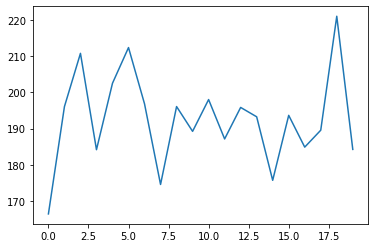

In [29]:
plt.plot(history)